# **Trabajo práctico 0: Algoritmo de Maximización de la Esperanza**

Pre-requisitos para el notebook.

In [1]:
import torch
import math
import numpy as np
import random
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib import style
from scipy.stats import norm
# Requerido para algoritmo de maximización de la esperanza, de lo contrario se mezclan todos los plots.
%matplotlib inline 
style.use('default')
torch.set_printoptions(sci_mode=False)

pallet = ["#1F77B4", "#B41F77", "#77B41F"]

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device}")

Using cuda


## **1. (80 puntos) Algoritmo de Maximización de la Esperanza con datos artificiales (modelo Gaussiano)**

A continuación, implemente el algoritmo de maximización de la esperanza (descrito en el material del curso), usando la definición y descripción de las siguientes funciones como base:

1. **(15 puntos)** Implemente la función $\textit{generate\_data}$ la cual reciba la cantidad de observaciones unidimensionales total a generar $N$, y los parámetros correspondientes a $K=2$ funciones de densidad **Gaussianas**. Genere los datos siguiendo tales distribuciones, y retorne tal matriz de datos $X\in\mathbb{R}^{Nx1}$.

    a) Grafique los datos usando un scatter plot junto con las gráficas de los histogramas de los datos y las funciones de densidad de probabilidad **Gaussianas** usando los parámetros para inicializar los datos, en la misma figura (gráfico). Escoja 3 conjuntos de parámetros para mostrar los 3 dataset resultantes.

In [2]:
MU_SPREAD_COEFFICIENT = 20
MU_SHIFT_COEFFICIENT = 30
SIGMA_SPREAD_COEFFICIENT = 1.5
SIGMA_SHIFT_COEFFICIENT = 3

def generate_data_gaussian(n_observations: int, k_parameters: int = 2) -> torch.Tensor:
    mus = torch.randn(k_parameters) * MU_SPREAD_COEFFICIENT + MU_SHIFT_COEFFICIENT
    print("Mus: ", mus)
    sigmas = torch.abs(torch.randn(k_parameters) * SIGMA_SPREAD_COEFFICIENT + SIGMA_SHIFT_COEFFICIENT)
    print("Sigmas: ", sigmas)
    # Create distributions
    distributions = torch.distributions.Normal(mus, sigmas)
    # Exact samples
    samples = distributions.sample(torch.Size([n_observations,])).t()
    return samples

randomdata = generate_data_gaussian(20)

randomdata

Mus:  tensor([48.4016, 15.2603])
Sigmas:  tensor([3.2596, 2.8933])


tensor([[55.4889, 43.2817, 51.2861, 45.1348, 44.3985, 49.7566, 56.2458, 46.6844,
         51.4346, 50.0827, 47.8439, 47.2341, 49.5746, 48.6457, 50.1588, 50.6797,
         43.2948, 46.1736, 45.0346, 39.4156],
        [17.6705, 12.4715, 19.2492, 16.7317, 16.0296, 11.0432, 16.8024, 17.8415,
         11.7106, 16.3980,  9.3600, 16.9095, 17.6104, 18.8675,  8.4003, 15.3707,
         15.2566, 17.8186, 15.3864, 20.1279]])

Mus:  tensor([-4.9176, 68.8634])
Sigmas:  tensor([4.3430, 3.4621])


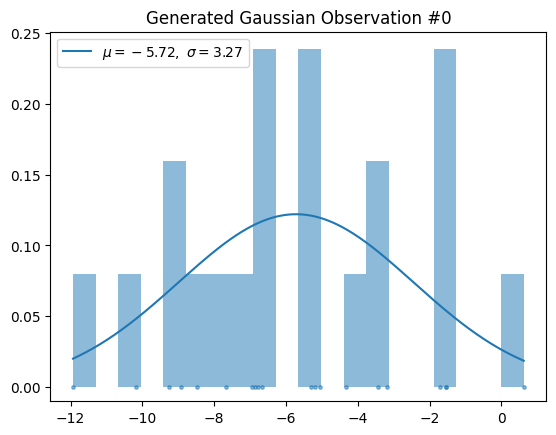

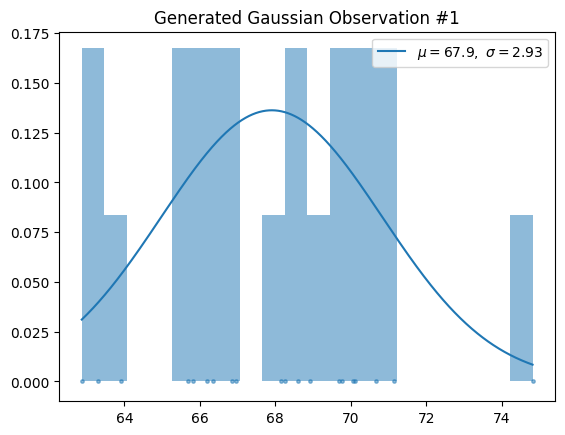

In [3]:
def plot_observation_2(observation, show=True, color=pallet[0], obs_number=1):
    fig, ax = plt.subplots()
    x_axis = torch.arange(observation.min(), observation.max(), 0.01)
    # Histogram
    ax.hist(observation, density=True, bins=20, alpha=0.5, color=color)
    # Scatter Dots
    ax.scatter(observation, torch.zeros(observation.size()), s=6, alpha=0.5, color=color)
    # Gaussian Curve
    mu = torch.mean(observation)
    sigma = torch.std(observation, unbiased=True)
    label = fr'$\mu={round(mu.item(), 2)},\ \sigma={round(sigma.item(), 2)}$'
    ax.plot(x_axis, norm.pdf(x_axis, mu, sigma), color=color, label=label)
    ax.set_title(f"Generated Gaussian Observation #{obs_number}")
    ax.legend()
    # Adjust y-axis
    y_min, y_max = ax.get_ylim()
    ax.set_ylim(y_min - 0.01, y_max)
    if show:
        plt.show()

sample = generate_data_gaussian(20)
plot_observation_2(sample[0], obs_number=0)
plot_observation_2(sample[1], obs_number=1)

2. **(5 puntos)** Implemente la función $\textit{init\_random\_parameters}$ la cual genere una matriz de $P\in\mathbb{R}^{Kx2}$ dimensiones, con los parámetros de las funciones de densidad **Gaussiana** generados completamente al azar.

    a) Muestre un pantallazo donde verifique su funcionamiento correcto con los comentarios asociados.

In [4]:
#  Genera una matriz k x 2 con mu y sigma aleatorios
def init_random_parameters(k_parameters=2):
    mus = torch.randn(k_parameters) * MU_SPREAD_COEFFICIENT + MU_SHIFT_COEFFICIENT
    sigmas = torch.abs(torch.randn(k_parameters) * SIGMA_SPREAD_COEFFICIENT + SIGMA_SHIFT_COEFFICIENT)
    return torch.stack((mus, sigmas), dim=1)

random_param = init_random_parameters(k_parameters=2)

random_param

tensor([[28.2877,  2.4197],
        [21.7014,  4.9017]])

3. **(20 puntos)** Implemente la función  $\textit{calculate\_likelihood\_gaussian\_observation(x\_n, mu\_k, sigma\_k)}$ la cual calcule la verosimilitud de una observación específica $X_{n}$, para una función de densidad Gaussiana con parámetros $\mu_{k}$ y $\sigma_{k}$.
Realice la correción pertinente al calculo de la función de verosimilitud para evitar el problema de $\textit{under flow}$.

    a) Diseñe y ejecute una prueba unitaria donde verifique su funcionamiento correcto con los comentarios asociados.

In [5]:
# TODO
def calculate_likelihood_gaussian_observation(x_n, mu_k, sigma_k):
    n = x_n.shape[0]
    return (-(n / 2) * torch.log(torch.tensor(2 * torch.pi)) - n * torch.log(torch.tensor(sigma_k)) - (
                1 / (2 * sigma_k ** 2)) * torch.sum((x_n - mu_k) ** 2))



4. **(10 puntos)** Implemente la función $\textit{calculate\_membership\_dataset(X\_dataset,Parameters\_matrix)}$, la cual, usando la matriz de parámetros $P$ y la función anteriormente implementada calculate_likelihood_gaussian_observation, defina por cada observación $X_{n}\in X$ la pertenencia o membresía a  cluster $k=1,...,K$, en una matriz binaria $M\in\mathbb{R}^{NxK}$. Retorne tal matriz de membresía $M$.

    a) Diseñe y ejecute una prueba unitaria donde verifique su funcionamiento correcto con los comentarios asociados

In [6]:
##Clase 4 de Deep learning 1 hora 10min

5. **(10 puntos)** Implemente la función $\textit{recalculate\_parameters(X\_dataset, Membership\_data)}$, la cual recalcule los parámetros de las funciones de densidad Gaussianas representandas en la matriz $P$, de acuerdo a lo representado en la matriz de membresía $M$.

    a)   Use las funciones $\textit{mean}$ y $\textit{std}$ de pytorch para ello. Intente prescindir al máximo de estructuras de repetición tipo $\textit{for}$.

In [7]:
# TODO

6. **(10 puntos)** Ejecute 5 corridas diferentes del algoritmo, donde por cada una documente los parámetros a los que se arribó, junto con los parámetros iniciales (describalo en una tabla). Hagalo para los 3 conjuntos de datos generados anteriormente.

    a) Grafique las funciones de densidad de probabilidad a las que convergió el algoritmo. Puede graficar también las funciones de densidad obtenidas en 2 o 3 pasos intermedios. Presente una tabla de gráficas donde en cada entrada se identifique el número de iteración y los parámetros iniciales.

    b) Comente los resultados.

In [8]:
# TODO

7. **(10 puntos)** Proponga una mejor heurística para inicializar los parámetros del modelo aleatoriamente.

    a) Compruebe la mejora obtenida con el método propuesto, corriendo las pruebas del punto anterior.

In [9]:
import torch
from torch_kmeans import KMeans

def heuristic_improvement(test_data,k=2):
   
    model = KMeans(n_clusters=k)

    test_data = test_data.unsqueeze(2)
    result = model(test_data)

    #print("Centers: ", result.centers)
    #print("Inertia: ",result.inertia)
        
    #Mu estimation
    centroides = result.centers
    centroides = centroides.flatten()
    #print("Tensor de centroides flat:", centroides)
    centroides = centroides[::k]
    #print("Centroids pares:", centroides)
    centroides = centroides.reshape(k,1)
    #print("Tensor de centroides ajustados:", centroides)
        
    # Sigma estimation
    inertia = result.inertia
    varianza = torch.zeros(k,1)

    for idx, elem in enumerate(inertia):
        varianza[idx]= test_data.size(1) / elem
        #print("Indice", test_data.size(1))
        #print("Elemento", elem)

    #varianza = torch.tensor(varianza)
    #varianza = varianza.reshape(k,1)
    #print("Tensor de varianza:", varianza)
    #print("Tensor de varianza:", varianza.size())

    new_params = torch.cat((centroides, varianza),dim=1)

    return new_params

sample_data = generate_data_gaussian(200,5)
heuristic_improvement(sample_data,sample_data.size(0))
#heuristic_improvement(randomdata)

Mus:  tensor([ 4.6038, 37.8718, 30.3404, 43.8894,  5.6644])
Sigmas:  tensor([3.6361, 6.2709, 2.2497, 3.5327, 4.8061])
Full batch converged at iteration 25/100 with center shifts = tensor([0., 0., 0., 0., 0.]).


tensor([[ 7.0849,  0.9903],
        [47.5647,  0.3207],
        [29.7035,  2.3308],
        [41.9338,  0.9683],
        [ 7.2405,  0.5767]])

## **2. (40 puntos) Algoritmo de Maximización de la Esperanza con datos artificiales (modelo Gamma)**

En esta sección, modificará el algoritmo de maximización de la esperanza anteriormente implementado para un modelo Gaussiano, para el modelo Gamma.

1. **(20 puntos)** Enliste e implemente todas las modificaciones necesarias tanto conceptualmente como en código para hacer que el algoritmo de maximización de la esperanza utilice un modelo Gamma

In [10]:
# TODO

2. **(5 puntos)** Implemente la función $\textit{generate\_data}$ la cual reciba la cantidad de observaciones unidimensionales total a generar $N$, y los parámetros correspondientes a $K = 2$funciones de densidad Gamma.Genere los datos siguiendo tales distribuciones, y retorne tal matriz de datos $N\in\mathbb{R}^{Nx1}$.

    a) Grafique los datos usando un $\textit{scatter plot}$ junto con las gráficas de los histogramas de los datos y las funciones de densidad de probabilidad **Gamma** usando los parámetros para inicializar los datos, en la misma figura (gráfico). Los parámetros serán escogidos por usted, muestre al menos 3 generaciones del dataset y comente el efecto de los parámetros.

In [11]:
# TODO

3.  **(10 puntos)** Ejecute 5 corridas diferentes del algoritmo, donde por cada una documente los parámetros a los que se arribó, junto con los parámetros iniciales (describalo en una tabla). Hagalo para los 3 conjuntos de datos generados anteriormente.

    a) Grafique las funciones de densidad de probabilidad a las que convergió el algoritmo. Puede graficar también las funciones de densidad obtenidas en 2 o 3 pasos intermedios. Presente una tabla de gráficas donde en cada entrada se identifique el número de iteración y los parámetros iniciales.

    1) Comente los resultados.

In [12]:
# TODO

4. **(5 puntos)** Explique cual es el comportamiento esperado de utilizar la implementación del algoritmo de maximización de esperanza para una distribución Gamma, con un conjunto de datos que sigue una distribución Gaussiana y viceversa.

    a) **(10 puntos)** Realice un diseño experimental donde verifique lo anterior

In [13]:
# TODO